# Temporal response functions

Temporal response functions (TRFs) are an alternative approach to understanding the relationship between stimulus events and M/EEG activity. The idea is to estimate a general linear model, with each row of the design matrix capturing a temporally-lagged version of the regressor of interest (Crosse 2016, Ehinger 2019). This can be used for discrete events (as in the current study), but can also be used for continuous, time-evolving regressors. 

A key advantage of this approach is that it allows for 'unmixing' of temporally-overlapping neural responses to an event (Smith 2015). On the other hand, if events are sufficiently temporally separated and discrete, then it is mathematically equivalent to event related averaging. The results from this approach should therefore be equivalent to those identifed in the EventRelatedFields notebook.

## Preparation

Import the relevant modules. We plan to use Julia+Unfold. Advice on how to install this is available at https://unfoldtoolbox.github.io/Unfold.jl/dev/generated/HowTo/juliacall_unfold/

In [15]:
import os.path as op
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne

from mne_bids import BIDSPath, read_raw_bids # If you don't have mne_bids installed, comment this line.

# Import the Julia package manager
from juliacall import Pkg as jlPkg
# Activate the environment in the current folder
jlPkg.activate(".")
# Install Unfold (in the activated environment)
jlPkg.add("Unfold")

[juliapkg] Found dependencies: /Users/lhunt/opt/anaconda3/lib/python3.9/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /Users/lhunt/opt/anaconda3/lib/python3.9/site-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ~1.6.1, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.3 to /Users/lhunt/opt/anaconda3/julia_env/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/mac/x64/1.10/julia-1.10.3-mac64.dmg
             downloaded 34.8 MB of 143.4 MB
             downloaded 76.9 MB of 143.4 MB
             downlo

  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Preferences ───────────────── v1.4.3
   Installed Parsers ───────────────────── v2.8.1
   Installed Scratch ───────────────────── v1.2.1
   Installed TableTraits ───────────────── v1.0.1
   Installed JSON3 ─────────────────────── v1.14.0
   Installed Tables ────────────────────── v1.11.1
   Installed DataAPI ───────────────────── v1.16.0
   Installed MicroMamba ────────────────── v0.1.14
   Installed Pidfile ───────────────────── v1.3.0
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed JLLWrappers ───────────────── v1.5.0
   Installed PrecompileTools ───────────── v1.2.1
   Installed PythonCall ────────────────── v0.9.20
   Installed DataValueInterfaces ───────── v1.0.0
   Installed micromamba_jll ────────────── v1.5.8+0
   Installed OrderedCollections ────────── v1.6.3
   Installed Requires ──────────────────── v1.3.0
   I

In [14]:
mtf.model.load_sample_data() # Load sample data 

AttributeError: module 'mtrf' has no attribute 'from_mne'

### Loading the data - if you have mne_bids installed

In [9]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
ica_suffix = 'ica'
ann_suffix = 'ann'
epo_suffix = 'epo'


preproc_root = r'/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/Preprocessing'
analysis_root = r'/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/Analysis'

bids_path_preproc = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=ica_suffix, datatype='meg',
            root=preproc_root, extension='.fif', check=False)

ann_fname = bids_path_preproc.basename.replace(ica_suffix, ann_suffix) # output filename
ann_fname = ann_fname.replace('fif', 'csv') # output filename

ann_fname_1 = op.join(bids_path_preproc.directory, ann_fname)
ann_fname_2 = ann_fname_1.replace('run-01', 'run-02')

Read the pre-processed data, after ICA. Note that we are *not* loading in the epoched data here, as we want to work with the continuous data instead.

In [7]:
# This section only runs on run=01 for illustration purpose 
bids_path_preproc.update(run='01')
raw = read_raw_bids(bids_path=bids_path_preproc, 
            extra_params={'preload':False},
            verbose=True)


Opening raw data file /Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Used Annotations descriptions: ['ITI', 'block_start', 'cue_left', 'cue_right', 'left_resp_maybe', 'right_resp_maybe', 'target_onset', 'trial_end', 'trial_start']


/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_27652/2927124242.py:3: RuntimeWarning: This filename (/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_27652/2927124242.py:3: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_27652/2927124242.py:3: RuntimeWarning: Did not find any channels

Now, read the events from the stimulus channel (STI101), and also read the artefacts that were detected in the ArtefactAnnotation script from the CSV file.

In [10]:
# Reading the events from the  raw file
events, events_id = mne.events_from_annotations(raw, event_id='auto')

# Reading the artifact rejection annotations
ann1 = mne.read_annotations(ann_fname_1)
print(ann1)
raw.set_annotations(ann1)

Used Annotations descriptions: ['ITI', 'block_start', 'cue_left', 'cue_right', 'left_resp_maybe', 'right_resp_maybe', 'target_onset', 'trial_end', 'trial_start']
<Annotations | 641 segments: BAD_muscle (98), blink (543)>


/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_27652/1187707891.py:7: RuntimeWarning: Omitted 641 annotation(s) that were outside data range.
  raw.set_annotations(ann1)


<Raw | sub-01_ses-01_task-SpAtt_run-01_ica.fif, 343 x 1434000 (1434.0 s), ~633 kB, data not loaded>

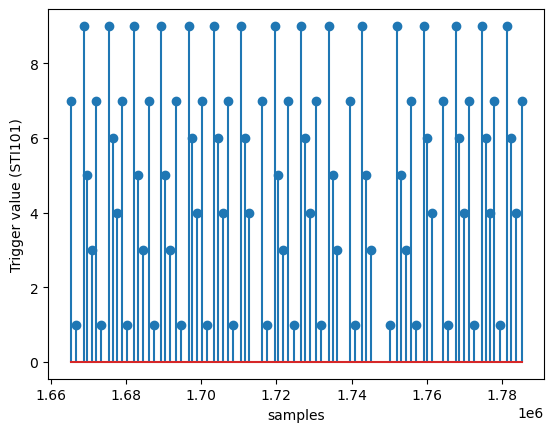

In [13]:
%matplotlib inline
plt.stem(events[:,0][:80], events[:,2][:80])
plt.xlabel('samples')
plt.ylabel('Trigger value (STI101)')
plt.show()

# References

Crosse MJ, Di Liberto GM, Bednar A and Lalor EC (2016) The Multivariate Temporal Response Function (mTRF) Toolbox: A MATLAB Toolbox for Relating Neural Signals to Continuous Stimuli. Front. Hum. Neurosci. 10:604. doi: 10.3389/fnhum.2016.00604

Ehinger BV, Dimigen O. 2019. Unfold: an integrated toolbox for overlap correction, non-linear modeling, and regression-based EEG analysis. PeerJ 7:e7838 https://doi.org/10.7717/peerj.7838

Smith NJ, Kutas M. Regression-based estimation of ERP waveforms: I. The rERP framework. Psychophysiology. 2015 Feb;52(2):157-68. doi: 10.1111/psyp.12317. Epub 2014 Aug 21. PMID: 25141770; PMCID: PMC5308234.
